In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for statistical visualization
plt.style.use('ggplot') # Set style for plotting

## Data Cleaning

In [2]:
# Read 10,000,000 rows so that the kernel won't died easily
train = pd.read_csv("input/train.csv", nrows = 10_000_000)

In [3]:
# Look at the top 3 rows of data
train.head(3)

key       ...         passenger_count
0   2009-06-15 17:26:21.0000001       ...                       1
1   2010-01-05 16:52:16.0000002       ...                       1
2  2011-08-18 00:35:00.00000049       ...                       2

[3 rows x 8 columns]

In [4]:
# Structure and data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 610.4+ MB


In [5]:
# Statistical analysis overlook
pd.set_option('float_format', '{:f}'.format) # Print entire number instead of x + ye

train.describe()

fare_amount       ...         passenger_count
count 10000000.000000       ...         10000000.000000
mean        11.338543       ...                1.684793
std          9.799930       ...                1.323423
min       -107.750000       ...                0.000000
25%          6.000000       ...                1.000000
50%          8.500000       ...                1.000000
75%         12.500000       ...                2.000000
max       1273.310000       ...              208.000000

[8 rows x 6 columns]

Well, some records are definitely wrong. I'll check those out now.

Obviously, a taxi can only have at most 5 passengers. ( that's think the 5th might be a baby)

In [6]:
train = train[train.fare_amount > 0]

In [7]:
train.shape

(9999311, 8)

In [8]:
train = train.loc[train.fare_amount < 600]

In [9]:
train.shape

(9999307, 8)

**The latitude of New York City, NY, USA is 40.730610, and the longitude is -73.935242. **

In [10]:
# So I set up a longitude range for the ride
train = train.loc[train.pickup_longitude < -71]
train = train.loc[train.pickup_longitude > -74.5]

In [11]:
train.shape

(9800169, 8)

In [12]:
# And a latitude range for the ride
train = train.loc[train.pickup_latitude < 42]
train = train.loc[train.pickup_latitude > 40]

In [13]:
train.shape

(9798711, 8)

In [14]:
train = train.loc[train.dropoff_longitude < -71]
train = train.loc[train.dropoff_longitude > -74.5]

In [15]:
train = train.loc[train.dropoff_latitude < 42]
train = train.loc[train.dropoff_latitude > 40]

In [16]:
train.shape

(9787911, 8)

In [17]:
train['longitude_diff'] = train['dropoff_longitude'] - train['pickup_longitude']

train['latitude_diff'] = train['dropoff_latitude'] - train['pickup_latitude']

In [18]:
train = train.loc[train.longitude_diff < 5]
train = train.loc[train.longitude_diff > -5]

In [19]:
train = train.loc[train.latitude_diff < 5]
train = train.loc[train.latitude_diff > -5]

In [20]:
train = train.loc[train.passenger_count > 0]
train = train.loc[train.passenger_count <= 7]

In [21]:
train.shape

(9753386, 10)

In [22]:
train.head()

key      ...        latitude_diff
0    2009-06-15 17:26:21.0000001      ...            -0.009041
1    2010-01-05 16:52:16.0000002      ...             0.070701
2   2011-08-18 00:35:00.00000049      ...            -0.010708
3    2012-04-21 04:30:42.0000001      ...             0.024949
4  2010-03-09 07:51:00.000000135      ...             0.015754

[5 rows x 10 columns]

## Feature Engineering (Derivative Features)

In [23]:
target = train[['fare_amount']]
train_df = train.drop('fare_amount',axis=1)
test = pd.read_csv("input/test.csv")

test['longitude_diff'] = test['dropoff_longitude'] - test['pickup_longitude']
test['latitude_diff'] = test['dropoff_latitude'] - test['pickup_latitude']

test_df = test
train_df['is_train'] = 1
test_df['is_train'] = 0
train_test = pd.concat([train_df,test_df],axis=0)

In [24]:
train_test['year'] = train_test.pickup_datetime.apply(lambda x: x[:4])

In [25]:
train_test['month'] = train_test.pickup_datetime.apply(lambda x: x[5:7])

In [26]:
train_test['hour'] = train_test.pickup_datetime.apply(lambda x: x[11:13])

In [27]:
import datetime

train_test['pickup_datetime'] = train_test.pickup_datetime.apply(
    lambda x: datetime.datetime.strptime(x[:10], '%Y-%m-%d'))

In [28]:
train_test['day_of_week'] = train_test.pickup_datetime.apply(lambda x: x.weekday())

In [29]:
train_test['pickup_date'] = train_test.pickup_datetime.apply(lambda x: x.date())

In [30]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2009-01-01', end='2015-12-31').to_pydatetime()

train_test['holidat_or_not'] = train_test.pickup_datetime.apply(lambda x: 1 if x in holidays else 0)

In [31]:
train_test = train_test.drop(['key','pickup_datetime','pickup_date'],axis=1)

In [32]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9763300 entries, 0 to 9913
Data columns (total 13 columns):
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
longitude_diff       float64
latitude_diff        float64
is_train             int64
year                 object
month                object
hour                 object
day_of_week          int64
holidat_or_not       int64
dtypes: float64(6), int64(4), object(3)
memory usage: 1.0+ GB


In [33]:
train_test['year'] = train_test['year'].astype('int')
train_test['hour'] = train_test['hour'].astype('int')

In [34]:
train_test.head()

pickup_longitude       ...        holidat_or_not
0        -73.844311       ...                     0
1        -74.016048       ...                     0
2        -73.982738       ...                     0
3        -73.987130       ...                     0
4        -73.968095       ...                     0

[5 rows x 13 columns]

## Clustering

I want to cluster the longtitude and latitude into 6 clusters, and make them dummy variables.

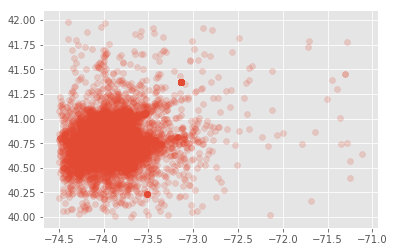

In [35]:
plt.scatter(train_test['pickup_longitude'],train_test['pickup_latitude'],alpha=0.2)

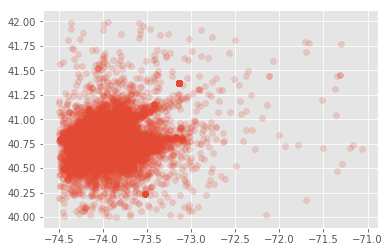

In [36]:
plt.scatter(train_test['dropoff_longitude'],train_test['dropoff_latitude'],alpha=0.2)

In [37]:
test = train_test[train_test['pickup_longitude'] < -73]
test = test[test['pickup_latitude'] < 41.5]

test.head()

pickup_longitude       ...        holidat_or_not
0        -73.844311       ...                     0
1        -74.016048       ...                     0
2        -73.982738       ...                     0
3        -73.987130       ...                     0
4        -73.968095       ...                     0

[5 rows x 13 columns]

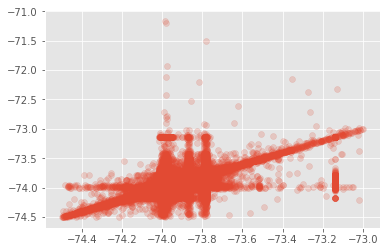

In [38]:
plt.scatter(test['pickup_longitude'],test['dropoff_longitude'],alpha=0.2)

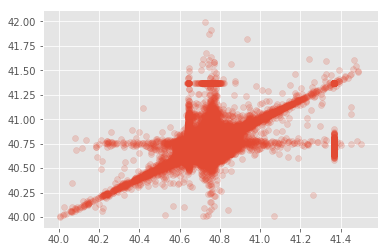

In [39]:
plt.scatter(test['pickup_latitude'],test['dropoff_latitude'],alpha=0.2)

In [40]:
from sklearn.cluster import KMeans

train_test_geo = train_test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]

model = KMeans(n_clusters = 4)
model.fit(train_test_geo)
labels = model.predict(train_test_geo)

In [41]:
train_test['cluster'] = labels

clusters = pd.get_dummies(train_test['cluster'],prefix='Cluster',drop_first=False)

train_test = pd.concat([train_test,clusters],axis=1).drop('cluster',axis=1)

In [42]:
train = train_test[train_test.is_train == 1].drop(['is_train'],axis=1)
test = train_test[train_test.is_train == 0].drop(['is_train'],axis=1)

In [43]:
train.head()

pickup_longitude  pickup_latitude    ...      Cluster_2  Cluster_3
0        -73.844311        40.721319    ...              0          0
1        -74.016048        40.711303    ...              0          0
2        -73.982738        40.761270    ...              0          0
3        -73.987130        40.733143    ...              0          0
4        -73.968095        40.768008    ...              0          1

[5 rows x 16 columns]

In [44]:
test.head()

pickup_longitude  pickup_latitude    ...      Cluster_2  Cluster_3
0        -73.973320        40.763805    ...              0          0
1        -73.986862        40.719383    ...              0          0
2        -73.982524        40.751260    ...              0          0
3        -73.981160        40.767807    ...              0          0
4        -73.966046        40.789775    ...              0          1

[5 rows x 16 columns]

## Simple Exploratory

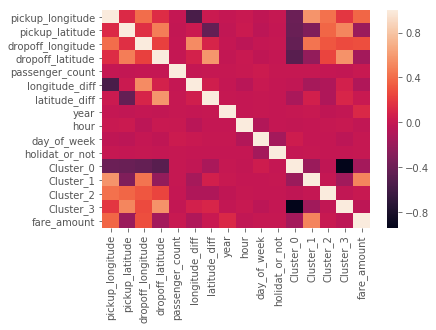

In [45]:
train['fare_amount'] = target

matrix = train.corr()
sns.heatmap(matrix)

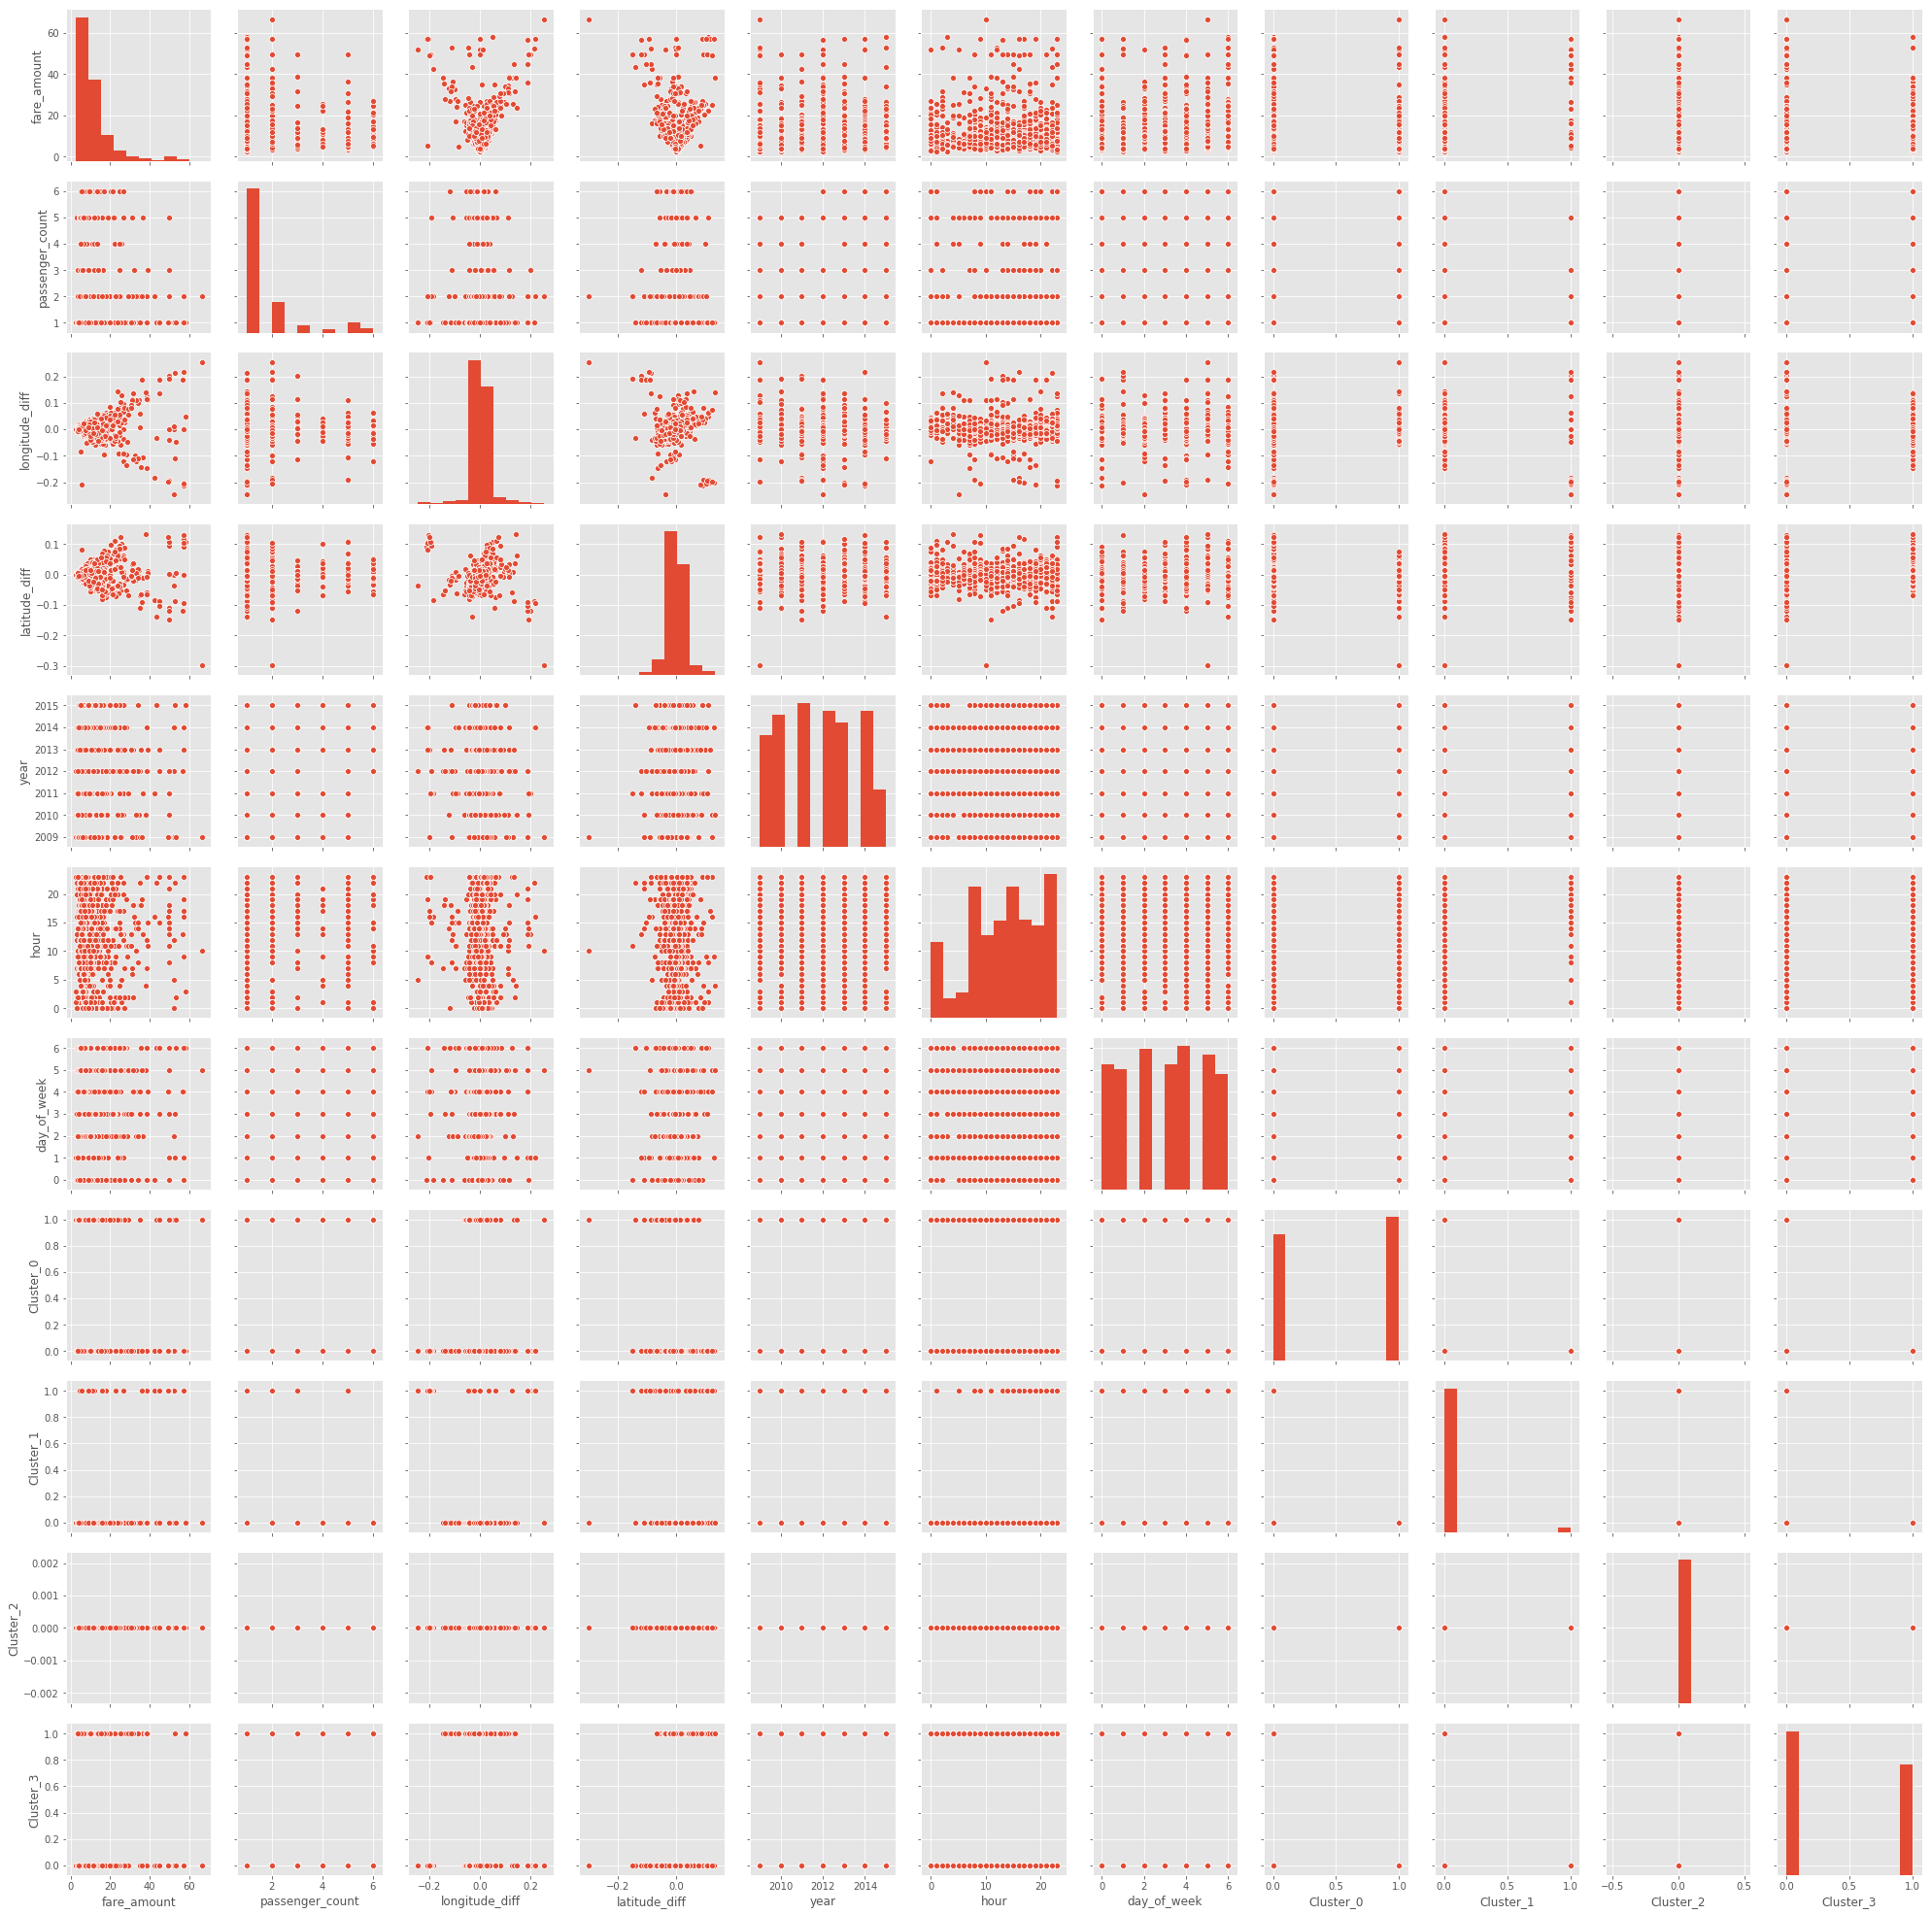

In [46]:
train_subset = train[:1000]
sns.pairplot(train_subset, vars=['fare_amount', 'passenger_count', 'longitude_diff','latitude_diff',
                          'year', 'hour', 'day_of_week','Cluster_0','Cluster_1','Cluster_2','Cluster_3'])

## Modeling

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [48]:
X = train.drop('fare_amount',axis=1)
y = train[['fare_amount']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
from sklearn.model_selection import GridSearchCV

scorer = metrics.make_scorer(metrics.mean_squared_error)

clf = RandomForestRegressor()

parameters = {'n_estimators': [25], 'max_features': [5,15], 'max_depth': [15,30],
              'min_samples_split':[3],'min_samples_leaf':[2], 'random_state':[0]}

grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

error = np.sqrt(metrics.mean_squared_error(y_test,best_predictions))
print(error)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was 

3.858659304435119


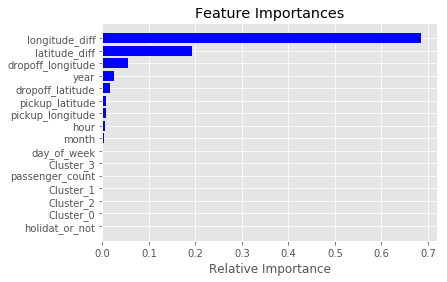

In [50]:
features = X.columns[:X.shape[1]]
importances = best_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [51]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [52]:
predictions = best_clf.predict(test)

submission = pd.read_csv("input/sample_submission.csv")
submission['fare_amount'] = predictions
submission.to_csv('submission.csv',index=False)